In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pykalman import KalmanFilter
from sklearn.linear_model import LinearRegression

#I had warning saying that "Future versions of pandas will require you to explicitly register matplotlib converters."
#And told me to import the code below to fix the warning
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
X_columns = ['temperature', 'cpu_percent', 'fan_rpm', 'sys_load_1']
y_column = 'next_temp'

In [3]:
def get_data(filename):
    """
    Read the given CSV file. Returns sysinfo DataFrames for training and testing.
    """
    sysinfo = pd.read_csv(filename, parse_dates=['timestamp'])
    
    # TODO: add the column that we want to predict: the temperatures from the *next* time step.
    sysinfo[y_column] = sysinfo['temperature'].shift(periods=1) # should be the temperature value from the next row
    sysinfo = sysinfo[sysinfo[y_column].notnull()] # the last row should have y_column null: no next temp known
    
    # return most of the data to train, and pick an interesting segment to test
    split1 = int(sysinfo.shape[0] * 0.8)
    split2 = int(sysinfo.shape[0] * 0.84)
    train = sysinfo.iloc[:split1, :]
    test = sysinfo.iloc[split1:split2, :]
    
    return train, test


def get_trained_coefficients(X_train, y_train):
    """
    Create and train a model based on the training_data_file data.

    Return the model, and the list of coefficients for the 'X_columns' variables in the regression.
    """
    
    # TODO: create regression model and train.
    model = LinearRegression().fit(X_train, y_train)
    coefficients = model.coef_
    #intercept = model.intercept_
    return model, coefficients


def output_regression(coefficients):
    regress = ' + '.join('%.3g*%s' % (coef, col) for col, coef in zip(X_columns, coefficients))
    print('next_temp = ' + regress)


def plot_errors(model, X_valid, y_valid):
    plt.hist(y_valid - model.predict(X_valid), bins=100)
    plt.savefig('test_errors.png')


def smooth_test(coef, sysinfo):
    X_valid, y_valid = sysinfo[X_columns], sysinfo[y_column]
    
    # feel free to tweak these if you think it helps.
    transition_stddev = 2.0
    observation_stddev = 2.0

    dims = X_valid.shape[-1]
    initial = X_valid.iloc[0]
    observation_covariance = np.diag([observation_stddev, 2, 10, 1]) ** 2
    transition_covariance = np.diag([transition_stddev, 80, 100, 10]) ** 2
    
    # Transition = identity for all variables, except we'll replace the top row
    # to make a better prediction, which was the point of all this.
    transition = np.eye(dims) # identity matrix, except...
    
    # TODO: replace the first row of transition to use the coefficients we just calculated (which were passed into this function as coef.).
    transition[0]=coef
    kf = KalmanFilter(
        initial_state_mean=initial,
        initial_state_covariance=observation_covariance,
        observation_covariance=observation_covariance,
        transition_covariance=transition_covariance,
        transition_matrices=transition,
    )

    kalman_smoothed, _ = kf.smooth(X_valid)

    plt.figure(figsize=(15, 6))
    plt.plot(sysinfo['timestamp'], sysinfo['temperature'], 'b.', alpha=0.5)
    plt.plot(sysinfo['timestamp'], kalman_smoothed[:, 0], 'g-')
    plt.savefig('smoothed.png')

next_temp = 0.611*temperature + 0.0125*cpu_percent + 0.0325*fan_rpm + 1.2*sys_load_1


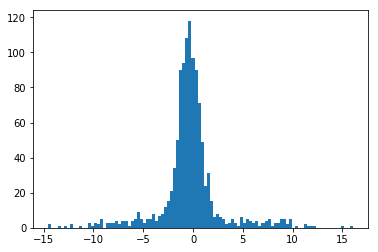

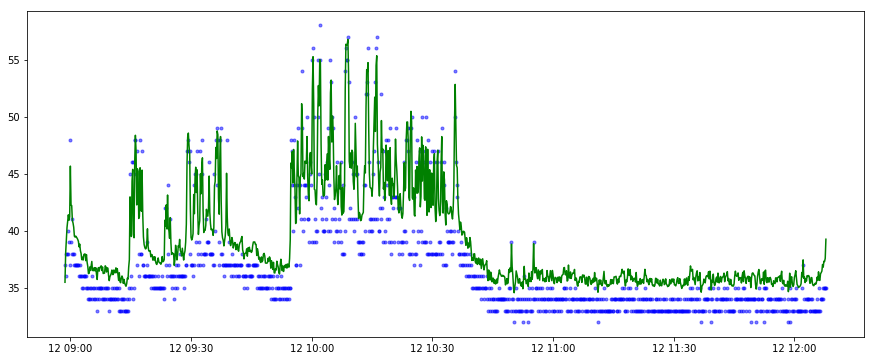

In [4]:
def main():
    train, test = get_data('sysinfo.csv')
    #train, test = get_data(sys.argv[1])
    X_train, y_train = train[X_columns], train[y_column]
    X_valid, y_valid = test[X_columns], test[y_column]

    model, coefficients = get_trained_coefficients(X_train, y_train)
    output_regression(coefficients)
    #print("Training score: %g\nTesting score: %g" % (model.score(X_train, y_train), model.score(X_valid, y_valid)))

    plot_errors(model, X_valid, y_valid)
    smooth_test(coefficients, test)


if __name__ == '__main__':
    main()